In [21]:
#Imports
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import math
import os
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline

In [22]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [23]:
#Quantize functions
def quantize(v, s, p, isActivation):
    # v: Input tensor
    # s: Step size, a learnable parameter specific to weight or activation layer being quantized
    # p: Quantization bits of precision
    # isActivation: True if v is activation tensor,
    # False if v is weight tensor
    # Compute configuration values
    if isActivation:
        Qn = -2**(p-1)
        Qp = 2**(p-1) - 1
        gradScaleFactor = 1 / math.sqrt(numOfIndividualElements(v) * Qp)
    else: # is weights
        Qn = -2**(p-1)
        Qp = 2**(p-1) - 1
        gradScaleFactor = 1 / math.sqrt(numOfIndividualElements(v) * Qp)
    # Quantize
    s = gradscale(s, gradScaleFactor)
    v = v / s
    v = torch.clip(v, Qn, Qp)
    vbar = roundpass(v)
    vhat = vbar * s
    return vhat

def roundpass(x):
    # x: Input tensor
    yOut = torch.round(x) # Round to nearest
    yGrad = x
    y = torch.detach(yOut - yGrad) + yGrad # Return yOut in forward, pass gradient to yGrad in backward
    return y

def gradscale(x, scale):
    # x: Input tensor
    # scale: Scale gradient by this
    yOut = x
    yGrad = x * scale
    y = torch.detach(yOut - yGrad) + yGrad # Return yOut in forward, pass gradient to yGrad in backward
    return y

def numOfIndividualElements(x):
    return len(torch.flatten(x))

In [24]:
#Quantized Model
layers=["layer1.0", "layer1.1","layer2.0", "layer2.1","fc","fc1","fc2"]
class QuantizedLeNet5(nn.Module):
    p = 8
    steps=[]
    activationSteps=[]
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(quantize(x,self.activationSteps[0],self.p,True))
        out = self.layer2(quantize(out,self.activationSteps[1],self.p,True))
        out = out.reshape(out.size(0), -1)
        out = self.fc(quantize(out,self.activationSteps[2],self.p,True))
        out = self.relu(out)
        out = self.fc1(quantize(out,self.activationSteps[3],self.p,True))
        out = self.relu1(out)
        out = self.fc2(quantize(out,self.activationSteps[4],self.p,True))
        return out
    
    def setWeights(self, params):
        dictionary={}
        for index, i in enumerate(layers):
            dictionary[i+".weight"] = quantize(params[i+".weight"], self.steps[index], self.p, False)
            dictionary[i+".bias"] = quantize(params[i+".bias"], self.steps[index], self.p, False)
        dictionary["layer1.1.running_mean"]=params["layer1.1.running_mean"]
        dictionary["layer1.1.running_var"]=params["layer1.1.running_var"]
        dictionary["layer2.1.running_mean"]=params["layer2.1.running_mean"]
        dictionary["layer2.1.running_var"]=params["layer2.1.running_var"]
        self.load_state_dict(dictionary)

In [25]:
def train(epochs,loader, device, model, cost, optimizers, test_loader,verbose=True, toQuantize=None):
    total_step = len(loader)
    error_list=[]
    epoch_list=[]
    accuracy_list=[]
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(loader): 
            if toQuantize!=None:
                model.setWeights(toQuantize.state_dict())
            images = images.to(device)
            labels = labels.to(device)
            
            #Forward pass
            outputs = model(images)
            loss = cost(outputs, labels)
                
            # Backward and optimize
            for optimizer in optimizers:
                optimizer.zero_grad()
            loss.backward()
            if toQuantize!=None:
                toQuantize.layer1[0].weight.grad = model.layer1[0].weight.grad
                toQuantize.layer1[1].weight.grad = model.layer1[1].weight.grad
                toQuantize.layer2[0].weight.grad = model.layer2[0].weight.grad
                toQuantize.layer2[1].weight.grad = model.layer2[1].weight.grad
                toQuantize.fc.weight.grad = model.fc.weight.grad
                toQuantize.fc1.weight.grad = model.fc1.weight.grad
                toQuantize.fc2.weight.grad = model.fc2.weight.grad
            for optimizer in optimizers:
                optimizer.step()
            if (i+1) % 400 == 0 and verbose:
                accuracy = evaluate(model,test_loader,toQuantize=toQuantize)
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, accuracy: {:.4f} %' 
                            .format(epoch+1, epochs, i+1, total_step, loss.item(), accuracy))
                error_list.append(loss.item())
                epoch_list.append(epoch)
                accuracy_list.append(accuracy)
    return epoch_list, error_list, accuracy_list

@torch.no_grad
def evaluate(model, loader, device="cpu", toQuantize=None):
    correct = 0
    total = 0
    # if toQuantize!=None:
    #         model.setWeights(toQuantize.state_dict())
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return 100 * correct / total
    # print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

In [26]:
#Variables
batch_size=64
def dataset():
    train_data = datasets.MNIST('./data/mnist', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
    test_data = datasets.MNIST('./data/mnist', train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize((32,32)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1325,), (0.3105,))
                               ]))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader
train_loader, test_loader = dataset()

p = 8
Qmax = 2**(p-1)-1
Qmin = -2**(p-1)

num_classes = 10
learning_rate = 0.001
num_epochs = 10
device = "cpu"

#For graph
quant_error=[]
quant_epochs=[]
quant_accuracy=[]
orig_error=[]
orig_epochs=[]
orig_accuracy=[]

In [27]:
#Training original model
orig_model = LeNet5(10)
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(orig_model.parameters(), lr=learning_rate)

orig_epochs, orig_error, orig_accuracy = train(num_epochs, train_loader, "cpu", orig_model, cost, [optimizer],test_loader)
torch.save(orig_model, "lenet5.pt")

Epoch [1/10], Step [400/938], Loss: 2.2206, accuracy: 34.5300 %
Epoch [1/10], Step [800/938], Loss: 2.1171, accuracy: 41.4100 %
Epoch [2/10], Step [400/938], Loss: 1.8464, accuracy: 53.7100 %
Epoch [2/10], Step [800/938], Loss: 1.6905, accuracy: 64.9100 %
Epoch [3/10], Step [400/938], Loss: 1.3748, accuracy: 74.8800 %
Epoch [3/10], Step [800/938], Loss: 0.9985, accuracy: 80.1500 %
Epoch [4/10], Step [400/938], Loss: 0.7814, accuracy: 85.4000 %
Epoch [4/10], Step [800/938], Loss: 0.5703, accuracy: 87.3200 %
Epoch [5/10], Step [400/938], Loss: 0.4691, accuracy: 89.4200 %
Epoch [5/10], Step [800/938], Loss: 0.4857, accuracy: 90.6700 %
Epoch [6/10], Step [400/938], Loss: 0.2470, accuracy: 91.7000 %
Epoch [6/10], Step [800/938], Loss: 0.2501, accuracy: 92.3300 %
Epoch [7/10], Step [400/938], Loss: 0.2194, accuracy: 93.2700 %
Epoch [7/10], Step [800/938], Loss: 0.2397, accuracy: 93.5400 %
Epoch [8/10], Step [400/938], Loss: 0.1596, accuracy: 94.0800 %
Epoch [8/10], Step [800/938], Loss: 0.33

In [28]:
#Initialize activation steps
quantModel = QuantizedLeNet5(10)
model = torch.load("lenet5.pt")
t=0
n=0
for image,_ in test_loader:
    flat_img = torch.flatten(image)
    t+= flat_img.sum()
    n+=len(torch.flatten(image))
activation_steps = [torch.tensor(2*(t/n)/math.sqrt(Qmax),requires_grad=True)] * 5
activation_steps

/var/folders/n1/xzlv_l050l51pv993nmt4rpm0000gn/T/ipykernel_15317/3933611597.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  activation_steps = [torch.tensor(2*(t/n)/math.sqrt(Qmax),requires_grad=True)] * 5


[tensor(0.0001, requires_grad=True),
 tensor(0.0001, requires_grad=True),
 tensor(0.0001, requires_grad=True),
 tensor(0.0001, requires_grad=True),
 tensor(0.0001, requires_grad=True)]

In [29]:
#Initialize weight steps
steps=[]
params = model.state_dict()
for layer in layers:
    weight = params[layer+".weight"]
    bias = params[layer+".bias"]
    steps.append(2*torch.mean(torch.cat((torch.flatten(weight) ,torch.flatten(bias))))/math.sqrt(Qmax))

In [30]:
#Trained quantized model
quantModel.steps = steps
quantModel.activationSteps = activation_steps

cost = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer2 = torch.optim.SGD(quantModel.steps, lr=learning_rate)
optimizer3 = torch.optim.SGD(quantModel.activationSteps, lr=learning_rate)

#Train
quant_epochs, quant_error, quant_accuracy = train(epochs=num_epochs,loader=train_loader,device="cpu",model=quantModel,cost=cost,optimizers=[optimizer1,optimizer2,optimizer3],test_loader=test_loader,toQuantize=model)
            

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)


Epoch [1/10], Step [400/938], Loss: 0.5068, accuracy: 89.4000 %
Epoch [1/10], Step [800/938], Loss: 0.0592, accuracy: 95.6300 %
Epoch [2/10], Step [400/938], Loss: 0.0946, accuracy: 96.5500 %
Epoch [2/10], Step [800/938], Loss: 0.1790, accuracy: 96.9100 %
Epoch [3/10], Step [400/938], Loss: 0.1003, accuracy: 97.3700 %
Epoch [3/10], Step [800/938], Loss: 0.1170, accuracy: 97.8700 %
Epoch [4/10], Step [400/938], Loss: 0.0537, accuracy: 98.0800 %
Epoch [4/10], Step [800/938], Loss: 0.1552, accuracy: 97.8200 %
Epoch [5/10], Step [400/938], Loss: 0.0738, accuracy: 97.5000 %
Epoch [5/10], Step [800/938], Loss: 0.1156, accuracy: 97.8100 %
Epoch [6/10], Step [400/938], Loss: 0.0281, accuracy: 98.1000 %
Epoch [6/10], Step [800/938], Loss: 0.0298, accuracy: 98.0900 %
Epoch [7/10], Step [400/938], Loss: 0.0408, accuracy: 98.2000 %
Epoch [7/10], Step [800/938], Loss: 0.0469, accuracy: 98.0700 %
Epoch [8/10], Step [400/938], Loss: 0.1475, accuracy: 97.6600 %
Epoch [8/10], Step [800/938], Loss: 0.02

In [31]:
#Converting type
params = quantModel.state_dict()
steps = quantModel.steps
int_params = {}

for index, i in enumerate(layers):
    weight = torch.round(params[i+".weight"]/steps[index]).to(torch.int8)
    bias = torch.round(params[i+".bias"]/steps[index]).to(torch.int8)

    int_params[i+".weight"] = weight
    int_params[i+".bias"] = bias
int_params["layer1.1.running_mean"]=params["layer1.1.running_mean"]
int_params["layer1.1.running_var"]=params["layer1.1.running_var"]
int_params["layer2.1.running_mean"]=params["layer2.1.running_mean"]
int_params["layer2.1.running_var"]=params["layer2.1.running_var"]
quantModel.load_state_dict(int_params)

quantModel.state_dict()


OrderedDict([('layer1.0.weight',
              tensor([[[[-128.,  127.,  127., -128., -128.],
                        [ 127.,  127.,  127., -128., -128.],
                        [ 127.,  127., -128., -128., -128.],
                        [ 127.,  127., -128., -128., -128.],
                        [ 127.,  127.,  127., -128., -128.]]],
              
              
                      [[[-128.,  127.,  127.,  127., -128.],
                        [-128.,  127., -128.,  127.,  127.],
                        [ 127.,  127.,  127.,  127.,  127.],
                        [ 127.,  127.,  127.,  127.,  127.],
                        [ 127.,  127.,  127.,  127.,  127.]]],
              
              
                      [[[ 127.,  127., -128., -128., -128.],
                        [  36., -128., -128., -128., -128.],
                        [-128., -128., -128., -128., -128.],
                        [-128., -128., -128., -128.,  127.],
                        [-128., -128.,  127.,  12

In [32]:
if(not os.path.isdir("output")):
    os.mkdir("output")

torch.save(int_params,"output/quantizedLeNet5Params.pt")
torch.save(quantModel.steps,"output/quantParamSteps.pt")
torch.save(quantModel.activationSteps,"output/quantActivationSteps.pt")

print(int_params, quantModel.steps, quantModel.activationSteps)

torch.save(orig_model.state_dict(),"output/LeNet5Params.pt")

orig_size = os.path.getsize("output/LeNet5Params.pt")/1e3
quantizedSize = os.path.getsize("output/quantizedLeNet5Params.pt")/1e3 + os.path.getsize("output/quantParamSteps.pt")/1e3 + os.path.getsize("output/quantActivationSteps.pt")/1e3

print("original: ", orig_size,"KB")
print("quantized: ",quantizedSize,"KB")
print("Compression Rate: ",(quantizedSize/orig_size) * 100,"%")

{'layer1.0.weight': tensor([[[[-128,  127,  127, -128, -128],
          [ 127,  127,  127, -128, -128],
          [ 127,  127, -128, -128, -128],
          [ 127,  127, -128, -128, -128],
          [ 127,  127,  127, -128, -128]]],


        [[[-128,  127,  127,  127, -128],
          [-128,  127, -128,  127,  127],
          [ 127,  127,  127,  127,  127],
          [ 127,  127,  127,  127,  127],
          [ 127,  127,  127,  127,  127]]],


        [[[ 127,  127, -128, -128, -128],
          [  36, -128, -128, -128, -128],
          [-128, -128, -128, -128, -128],
          [-128, -128, -128, -128,  127],
          [-128, -128,  127,  127,  127]]],


        [[[-128, -128, -128, -128, -128],
          [-128, -128, -128, -128, -128],
          [ 127, -128, -128, -128, -128],
          [ 127,  127,  127,  127,  127],
          [ 127,  127,  127,  127,  127]]],


        [[[-128, -128, -128,  127,  127],
          [-128, -128, -128, -128,  127],
          [ 127, -128, -128, -128, -128]

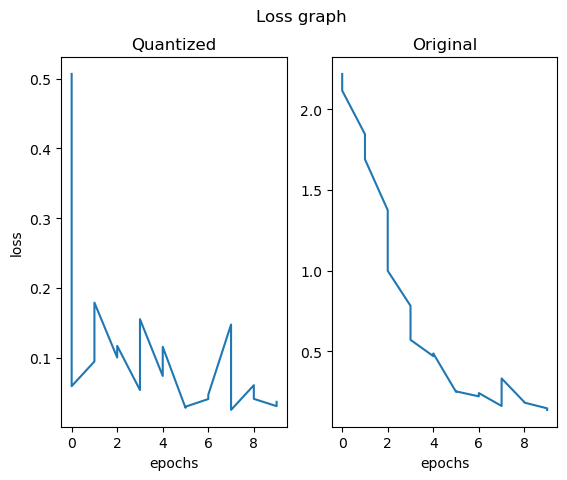

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(quant_epochs, quant_error)
ax2.plot(orig_epochs, orig_error)
fig.suptitle("Loss graph")

ax1.set_title("Quantized")
ax1.set(xlabel="epochs",ylabel="loss")

ax2.set_title("Original")
ax2.set(xlabel="epochs")
plt.show()

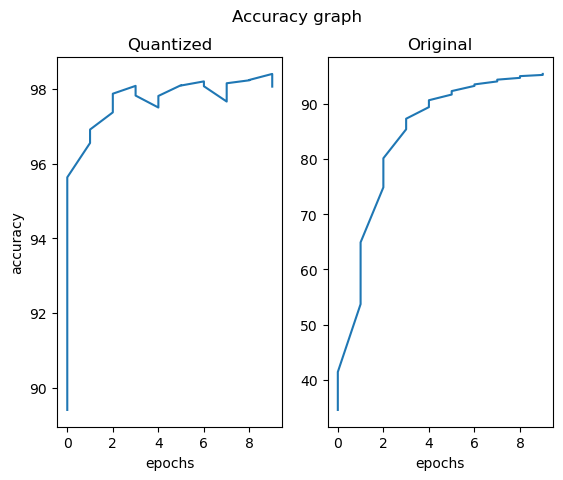

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(quant_epochs, quant_accuracy)
ax2.plot(orig_epochs, orig_accuracy)
fig.suptitle("Accuracy graph")

ax1.set_title("Quantized")
ax1.set(xlabel="epochs",ylabel="accuracy")

ax2.set_title("Original")
ax2.set(xlabel="epochs")
plt.show()

In [35]:
#testing
state_dict = torch.load("output/quantizedLeNet5Params.pt")
activation_steps = torch.load("output/quantActivationSteps.pt")
weight_steps = torch.load("output/quantParamSteps.pt")

#Dequantize
for index, i in enumerate(layers):
    weight = state_dict[i+".weight"]*steps[index]
    bias = state_dict[i+".bias"]*steps[index]

    state_dict[i+".weight"] = weight
    state_dict[i+".bias"] = bias

quantModel = QuantizedLeNet5(10)
quantModel.load_state_dict(state_dict)
quantModel.activationSteps = activation_steps
quantModel.steps = weight_steps
# print(state_dict, weight_steps, activation_steps)


print(evaluate(quantModel,test_loader),"%")

98.22 %
